# Finance Copilot - LangGraph Architecture

In [21]:
!git clone https://github.com/genaiconference/AgenticAI_GenAIHack.git

In [ ]:
!pip install -r /content/AgenticAI_GenAIHack/requirements_agenti_ai.txt

In [40]:
import os
os.chdir("/content/AgenticAI_GenAIHack")

In [38]:
import warnings
warnings.filterwarnings("ignore")
from typing import Literal
from typing import List, Sequence
import random
import numpy as np
from bs4 import BeautifulSoup
import functools, operator, requests, os, json
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_core.messages import BaseMessage, HumanMessage

from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder, PromptTemplate
from langgraph.graph import StateGraph, END
from langchain.tools import tool
from typing import Annotated, Any, Dict, List, Optional, Sequence, TypedDict
from IPython.display import Markdown, JSON

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain.tools.retriever import create_retriever_tool
from langchain_community.utilities import BingSearchAPIWrapper
from langchain.agents import Tool
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_community.callbacks import get_openai_callback

from langchain_core.output_parsers import PydanticOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field, validator
from langchain_core.output_parsers import JsonOutputParser
import ast
import re

from prompts import *
from utils import create_MVR, create_qa_agent, create_chat_agent

#### Load environment variables

In [25]:
import os
from dotenv import load_dotenv
load_dotenv(dotenv_path="/content/.env")

EMBEDDING_DEPLOYMENT_NAME = os.getenv('EMBEDDING_3_DEPLOYMENT_NAME')
EMBEDDING_API_KEY = os.getenv('EMBEDDING_3_API_KEY')
EMBEDDING_API_BASE = os.getenv('EMBEDDING_3_API_BASE')

GPT4_TURBO_DEPLOYMENT_NAME = os.getenv('GPT4_TURBO_DEPLOYMENT_NAME')
GPT4_OMNI_DEPLOYMENT_NAME = os.getenv('GPT4o_DEPLOYMENT_NAME')

API_KEY = os.getenv('sweden_API_KEY')
API_BASE = os.getenv('sweden_API_BASE')
API_TYPE = os.getenv('API_TYPE')
API_VERSION = os.getenv('API_VERSION')

#### Define LLM

In [26]:
from langchain_openai import AzureChatOpenAI
from langchain_openai import AzureOpenAIEmbeddings

embeddings = AzureOpenAIEmbeddings(
    azure_deployment=EMBEDDING_DEPLOYMENT_NAME,
    openai_api_key=EMBEDDING_API_KEY,
    azure_endpoint=EMBEDDING_API_BASE,
    openai_api_version=API_VERSION,
)

llm = AzureChatOpenAI(
        azure_endpoint=API_BASE,
        openai_api_version=API_VERSION,
        azure_deployment=GPT4_OMNI_DEPLOYMENT_NAME,
        openai_api_key=API_KEY,
        openai_api_type=API_TYPE,
        temperature=0)

### Define Tools

In [43]:
## Retriever Creation

vector_store_exists = True

_IFRS_ret = create_MVR('IFRS.pickle', embeddings, "IFRS", vectorstore_exists=vector_store_exists, k=7)

_annual_reports_ret = create_MVR('annual_reports.pickle', embeddings, "ANNUAL_REPORTS", vectorstore_exists=vector_store_exists, k=7)

_audit_ret = create_MVR('IFRS.pickle', embeddings, "KPMG", vectorstore_exists=vector_store_exists, k=7)

## Tool Creation

IFRS_tool = create_retriever_tool(retriever=_IFRS_ret,
                                  name = 'IFRS_Retriever',
                                  description="Use this tool to answer questions related to IFRS which is International Financial Reporting Standards.")

ANNUAL_REPORTS_tool = create_retriever_tool(retriever = _annual_reports_ret,
                                        name = "ANNUAL_REPORTS_RETRIEVER",
                                        description = "Use this tool when you need to answer questions related to annual reports, 10K reports or 20F reports of Novartis and it's competitors ('Roche','GSK','Bayer','AstraZeneca','Sanofi', 'Amgen','Abbvie', 'BMS' - Bristol Myers Squibb, 'Gilead', 'Eli Lilly', 'Merck', 'Pfizer', 'Takeda','Johnson&Johnson', 'novo-nordisk'). If no specific year is mentioned in the question, always look for latest available year")

AUDIT_tool = create_retriever_tool(retriever=_audit_ret,
                              name = 'AUDIT_Retriever',
                              description="Use this tool to answer questions related to the Auditor(KPMG, EY, PWC) Insights on IFRS which is International Financial Reporting Standards")

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [44]:
class CheckNodeState(TypedDict):
    """
    Represents the state of check nodes.

    Attributes:
        observation: observation found from the check node
    """
    observation: str


class SourceDetectNodeState(TypedDict):
    """
    Represents the state of check nodes.

    Attributes:
        observation: observation found from the check node
    """
    observation: List[str]



class ResponseNodeState(TypedDict):
    """
    Represents the state of Response nodes.

    Attributes:
        answer: answer generated
        metadata: metadata of the answer generated
    """

    answer: str
    metadata: Annotated[dict, operator.add]



def topic_modelling_node(state):
    """Use this tool to run topic modelling module and update the database with Question and Topic"""
    print("------ENTERING: TOPIC MODELLING NODE------")
    ## Write code here to get web answer

    print("============================================")
    print(state)
    print("============================================")

    topic = "DUMMY TOPIC"
    print(f"------OBSERVATION: {topic}------")
    return {"topic": topic}


class FinanceCheck_class(BaseModel):
    """Binary score for finance check on the user question."""
    binary_score: str = Field(description="Given a user question, return 'Yes' if is related to Finance/Accounting/Reporting else 'No'")


def get_finance_check(_llm, META_RESPONSE_PROMPT, state):
    parser = PydanticOutputParser(pydantic_object=FinanceCheck_class)
    prompt = PromptTemplate(template=META_RESPONSE_PROMPT,
                            input_variables=["question"],
                            partial_variables={"format_instructions": parser.get_format_instructions()},
                           )
    prompt_and_model = prompt | llm

    with get_openai_callback() as cb:
        output = prompt_and_model.invoke({"question": question})
        result = parser.invoke(output)
    return result.binary_score


def finance_check_node(state):
    """Use this tool to check whether the user question is about finance or general greeting."""
    observation = get_finance_check(llm, META_RESPONSE_PROMPT_DETAILED, state['question']) # random.choice(["Yes", "No"])

    print("------ENTERING: FINANCE CHECK NODE------")
    print(f"------OBSERVATION: {observation}------")

    finance_check: CheckNodeState = {"observation": observation}

    return {"finance_check": finance_check}


def get_generic_answer(_llm, META_ANSWER_PROMPT, question):
    with get_openai_callback() as cb:
        response = _llm.invoke(META_ANSWER_PROMPT.format(question=question))
    return response.content


def generic_response_node(state):
    """Use this tool to answer user generic questions"""
    print("------ENTERING: GENERIC RESPONSE NODE------")

    answer = get_generic_answer(llm, META_ANSWER_PROMPT, state['question'])

    generic_response: ResponseNodeState = {"answer": answer,
                                            "metadata": []}

    print(f"------ANSWER: {generic_response}------")
    return {"generic_response": generic_responsec, "final_answer": answer}


class RouteQuery_class(BaseModel):
    """Route a user query to the most relevant datasource."""
    datasource: Literal["FRA", "WEB"] = Field(description="Given a user question choose to route it to WEB or FRA.")

def get_query_rerouter_check(llm, QUERY_REROUTER_PROMPT, state):
    parser = PydanticOutputParser(pydantic_object=RouteQuery_class)

    prompt = PromptTemplate(template=QUERY_REROUTER_PROMPT,
                            input_variables=["question"],
                            partial_variables={"format_instructions": parser.get_format_instructions()},
                           )
    prompt_and_model = prompt | llm

    with get_openai_callback() as cb:
        output = prompt_and_model.invoke({"question": question})
        query_rerouter_check = parser.invoke(output)

    return query_rerouter_check.datasource


def query_rerouter_node(state):
    """Use this tool to check whether the user question needs an internet search to answer"""
    print("------ENTERING: QUERY REROUTER NODE------")
    observation = get_query_rerouter_check(llm, QUERY_REROUTER_PROMPT_DETAILED, state['question']) # random.choice(["Yes", "No"])

    print(f"------OBSERVATION: {observation}------")
    query_rerouter_check: CheckNodeState = {"observation": observation}
    return {"query_rerouter_check": query_rerouter_check}



def human_check_node(state):
    user_input = input("The answer is not available from the private data sources! Do you want me to search over the internet to answer?")
    human_response: ResponseNodeState = {"answer": user_input.lower(),
                                            "metadata": []}
    return {"human_response": human_response}



# Create a tool to processes content from a webpage
@tool("process_content", return_direct=False)
def process_content(url: str, chunk_size: int = 10000) -> str:
    """
    Use this tool to extract content from HTML pages and chunk it recursively.

    Args:
      url (str): The URL of the HTML page to process.
      chunk_size (int, optional): The maximum size of each text chunk. Defaults to 100000.

    Returns:
      str: The chunked text content extracted from the HTML page.
    """
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser',from_encoding="iso-8859-1")
    text = soup.get_text()

    def chunk_text(text, chunk_size):
        if len(text) <= chunk_size:
            return text
        else:
            midpoint = len(text) // 2
            left_chunk = chunk_text(text[:midpoint], chunk_size)
            right_chunk = chunk_text(text[midpoint:], chunk_size)
            return left_chunk + "\n" + right_chunk

        chunks = chunk_text(text, chunk_size)
        return chunks


@tool("bing_search", return_direct=False)
def bing_search(query: str) -> str:
    """Use this tool when you need to answer questions related to current events and latest happenings"""
    bing_search = BingSearchAPIWrapper()
    results = bing_search.results(query, 5)
    return results if results else "No results found."


def get_web_search_answer(state):
    tools = [bing_search, process_content]

    generate_prompt = """You are a web searcher trained to retrieve the current events from the internet. Search the internet for information.
                            Generate the best answer possible for the user's request with mandatory mention of the sources and the hyperlinks for the sources wherever it is possible.
                            Think step by step. Breakdown the question if it has multiple asks and finally merge your results.
                            Always crave for the best version of answer.
                            - **Always** before giving the final answer, try another method.Then reflect on the answers of the two methods you did and ask yourself if it answers correctly the original question. If you are not sure, try another method.
                            - If the methods tried do not give the same result, reflect and try again until you have two methods that have the same result.
                            - If you are sure of the correct answer, create a beautiful and thorough response.
                            ** DO NOT MAKE UP AN ANSWER OR USE YOUR PRIOR KNOWLEDGE, ONLY USE THE RESULTS OF THE CALCULATIONS YOU HAVE DONE **
                            PLEASE NOTE THAT IF NO SPECIFIC YEAR MENTIONED IN THE QUESTION, ALWAYS LOOK FOR THE LATEST YEAR.
                            """

    generate_agent = create_qa_agent(llm, tools, generate_prompt, verbose=False)
    with get_openai_callback() as cb:
        answer = generate_agent.invoke({"input": state['question']})
    return answer['output']

def web_search_node(state):
    """Use this tool when you need to answer questions related to current events and latest happenings"""
    print("------ENTERING: WEB SEARCH NODE------")
    ## Write code here to get answer
    response = get_web_search_answer(state)
    print(f"------WEB SEARCH ANSWER: {response}------")
    web_response: ResponseNodeState = {"answer": response,
                                        "metadata": []}
    return {"web_response": web_response, "final_answer": response}





def get_source_detector_check(llm, SOURCE_DETECTOR_PROMPT, selected_source_list, question):
    parser = JsonOutputParser()
    prompt = PromptTemplate(template=SOURCE_DETECTOR_PROMPT,
                            input_variables=["question"],
                            partial_variables={"role_based_sources": selected_source_list , "format_instructions": parser.get_format_instructions()},
                           )
    chain = prompt | llm | parser
    source_detector_check = chain.invoke({"question": question})

    return source_detector_check['Output']


def source_detector_node(state):
    """Use this tool to detect the sources needed for the question to answer"""
    print("------ENTERING: SOURCE DETECTOR NODE------")

    selected_source_list = ["ifrs_answer_node", "annual_reports_answer_node", "auditor_guidance_answer_node"]
    sources_detected = get_source_detector_check(llm, SOURCE_DETECTOR_PROMPT_DETAILED, selected_source_list, state['question'])
    print(sources_detected)
    print(f"------SOURCES DETECTED: {list(set(sources_detected))}------")
    source_detector_check: SourceDetectNodeState = {"observation": list(set(sources_detected))}
    return {"source_detector_check": source_detector_check}


def ifrs_answer_node(state):
    """Use this tool to answer ifrs related questions"""
    print("------ENTERING: IFRS ANSWER NODE------")

    tools = [IFRS_tool]
    generate_agent = create_qa_agent(llm, tools, IFRS_di_prompt, verbose=False)
    with get_openai_callback() as cb:
        answer = generate_agent.invoke({"input":state['question']})
    display(Markdown(f"""**IFRS ANSWER:** <font color="red">{answer['output']}</font>"""))
    ifrs_response: ResponseNodeState = {"answer": answer['output'],
                                        "metadata": []}
    return {"ifrs_response": ifrs_response}


def auditor_guidance_answer_node(state):
    """Use this tool to answer audit related questions"""
    print("------ENTERING: AUDITOR GUIDANCE ANSWER NODE------")
    tools = [AUDIT_tool]
    generate_agent = create_qa_agent(llm, tools, KPMG_EY_PwC_prompt, verbose=False)
    with get_openai_callback() as cb:
        answer = generate_agent.invoke({"input":state['question']})

    display(Markdown(f"""**IFRS ANSWER:** <font color="red">{answer['output']}</font>"""))
    audit_response: ResponseNodeState = {"answer": answer['output'],
                                        "metadata": []}
    return {"audit_response": audit_response}


def annual_reports_answer_node(state):
    """Use this tool to answer annual reports related questions"""
    print("------ENTERING: ANNUAL REPORTS ANSWER NODE------")
    all_competitors = ['Roche','GSK','Bayer','AstraZeneca','Sanofi', 'Amgen', 'Biogen', 'Abbvie', 'BMS/Bristol Myers Squibb', 'Gilead', 'Eli Lilly', 'Merck', 'Pfizer', 'Takeda','Johnson&Johnson', 'novo-nordisk']

    competitors = ['Roche', 'Sanofi', 'Bayer', 'GSK', 'AstraZeneca']
    web_tool = bing_search

    tools = [ANNUAL_REPORTS_tool, web_tool]
    generate_agent = create_qa_agent(llm, tools, AR_prompt, verbose=False)
    with get_openai_callback() as cb:
        answer = generate_agent.invoke({"input":state['question'], 'all_competitors':all_competitors, 'top5_competitors':competitors })
    display(Markdown(f"""**ANNUAL REPORTS ANSWER:** <font color="red">{answer['output']}</font>"""))
    annual_reports_response: ResponseNodeState = {"answer": answer['output'],
                                                    "metadata": []}
    return {"annual_reports_response": annual_reports_response}


def get_unified_response(_llm, unified_response_prompt, all_answers):
    with get_openai_callback() as cb:
        unified_response = _llm.invoke(unified_response_prompt.format(all_answers=all_answers))
    return unified_response.content


def unified_answer_node(state):
    """Use this tool to consolidate and give a unified answer"""
    print("------ENTERING: UNIFIED ANSWER NODE------")
    display(JSON(state))
    all_answers = ""
    node_response_dict = {"ifrs_answer_node": ["### IFRS: ", "ifrs_response"],
                             "annual_reports_answer_node": ["### Annual Reports: ", "annual_reports_response"],
                             "fm_answer_node": ["### Foundational ChatGPT: ", "fm_response"]}

    for source in node_response_dict.keys():
        if source in state['source_detector_check']['observation']:
            all_answers = (
                    all_answers
                    + node_response_dict[source][0]
                    + "\n"
                    + state[node_response_dict[source][1]]["answer"]
                    + "\n\n"
                    + "---"
                    + "\n\n"
                )

    answer = get_unified_response(llm, unified_response_prompt, all_answers)
    display(Markdown(f"""**UNIFIED ANSWER:** <font color="red">{answer}</font>"""))

    unified_response: ResponseNodeState = {"answer": answer,
                                            "metadata": []}

    all_answers = all_answers + "### Unified Response" +"\n" +answer + "\n\n"

    return {"unified_response": unified_response, "final_answer": all_answers}



def overall_status_check_node(state):
    """Use this tool to check the overall status and update the config settings"""
    print("------ENTERING: OVERALL STATUS CHECK NODE------")
    observation = "Completed"
    overall_status_check: CheckNodeState = {"observation": observation}
    print("-------------------------------- {} --------------------------------".format(red("Final Answer", ['bold'])))
    display(Markdown(f"""**FINAL ANSWER:** <font color="red">{state['final_answer']}</font>"""))

    return {"overall_status_check": overall_status_check}

In [45]:
from langgraph.graph import StateGraph
from typing_extensions import TypedDict
from typing import Annotated, List
from langchain_core.messages import AnyMessage
import operator


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        finance_check: whether user question needs finance answer or generic answer
        generic_response: generic answer
        query_rerouter_check: whether user question needs web search or fra sources to answer
        web_search: web answer
        source_detector: List of fra sources applicable for answering the user question
        ifrs_answer: ifrs answer
        annual_reports_answer: annual reports answer
        fm_answer: foundational model answer
        unified_answer: consistency check and unified answer
    """

    operation_id: int
    user_id: str
    question: str
    topic: str
    requested_datasources: List[str]
    final_answer: Annotated[str, operator.add]

    finance_check: CheckNodeState
    query_rerouter_check: CheckNodeState
    source_detector_check: SourceDetectNodeState
    overall_status_check: CheckNodeState

    generic_response: ResponseNodeState
    human_response: ResponseNodeState
    web_response: ResponseNodeState
    ifrs_response: ResponseNodeState
    annual_reports_response: ResponseNodeState
    audit_response: ResponseNodeState
    unified_response: ResponseNodeState
    intermediate_steps: Annotated[list[AnyMessage], operator.add]



## Main Graph

builder = StateGraph(GraphState)
builder.add_node("topic_modelling_node", topic_modelling_node)
builder.add_node("finance_check_node", finance_check_node)
builder.add_node("generic_response_node", generic_response_node)
builder.add_node("query_rerouter_node", query_rerouter_node)
builder.add_node("human_check_node", human_check_node)
builder.add_node("web_search_node", web_search_node)
builder.add_node("source_detector_node", source_detector_node)
builder.add_node("ifrs_answer_node", ifrs_answer_node)
builder.add_node("annual_reports_answer_node", annual_reports_answer_node)
builder.add_node("auditor_guidance_answer_node", auditor_guidance_answer_node)
builder.add_node("unified_answer_node", unified_answer_node)
builder.add_node("overall_status_check_node", overall_status_check_node)

builder.set_entry_point("topic_modelling_node")
builder.add_edge("topic_modelling_node", "finance_check_node")

def finance_check_edge(state):
    finance_check = state["finance_check"]

    if finance_check['observation'] == "Yes":
        print("------DECISION: INVOKE QUERY REROUTER NODE------")
        return "query_rerouter_node"
    else:
        print("------DECISION: INVOKE GENERIC RESPONSE NODE------")
        return "generic_response_node"


finance_check_possible_nodes = ["query_rerouter_node", "generic_response_node"]
builder.add_conditional_edges("finance_check_node", finance_check_edge, finance_check_possible_nodes)
builder.add_edge("generic_response_node", "overall_status_check_node")


def query_rerouter_edge(state):
    query_rerouter_check = state["query_rerouter_check"]

    if query_rerouter_check['observation'] == "FRA":
        print("------DECISION: INVOKE SOURCE DETECTOR NODE------")
        return "source_detector_node"
    else:
        print("------DECISION: CHECK WITH USER TO INVOKE WEB SEARCH NODE------")
        return "human_check_node"


query_rerouter_possible_nodes = ["human_check_node", "source_detector_node"]
builder.add_conditional_edges("query_rerouter_node", query_rerouter_edge, query_rerouter_possible_nodes)


def human_check_edge(state):
    if state['human_response']['answer'] == "yes":
        print("------DECISION: INVOKE WEB SEARCH NODE------")
        return "web_search_node"
    else:
        print("------Your question cannot be answered due to lack of information from private data sources, please ask a different question!------")
        return "overall_status_check_node"


builder.add_conditional_edges("human_check_node", human_check_edge, ["web_search_node", "overall_status_check_node"])

builder.add_edge("web_search_node", "overall_status_check_node")


def source_detector_edge(state) -> list:
    return state["source_detector_check"]['observation']


individual_answer_nodes = ["annual_reports_answer_node", "ifrs_answer_node", "auditor_guidance_answer_node"]
builder.add_conditional_edges("source_detector_node", source_detector_edge, individual_answer_nodes)

for node in individual_answer_nodes:
    builder.add_edge(node, "unified_answer_node")


builder.add_edge("unified_answer_node", "overall_status_check_node")
builder.set_finish_point("overall_status_check_node")

memory = SqliteSaver.from_conn_string(":memory:")
graph = builder.compile()

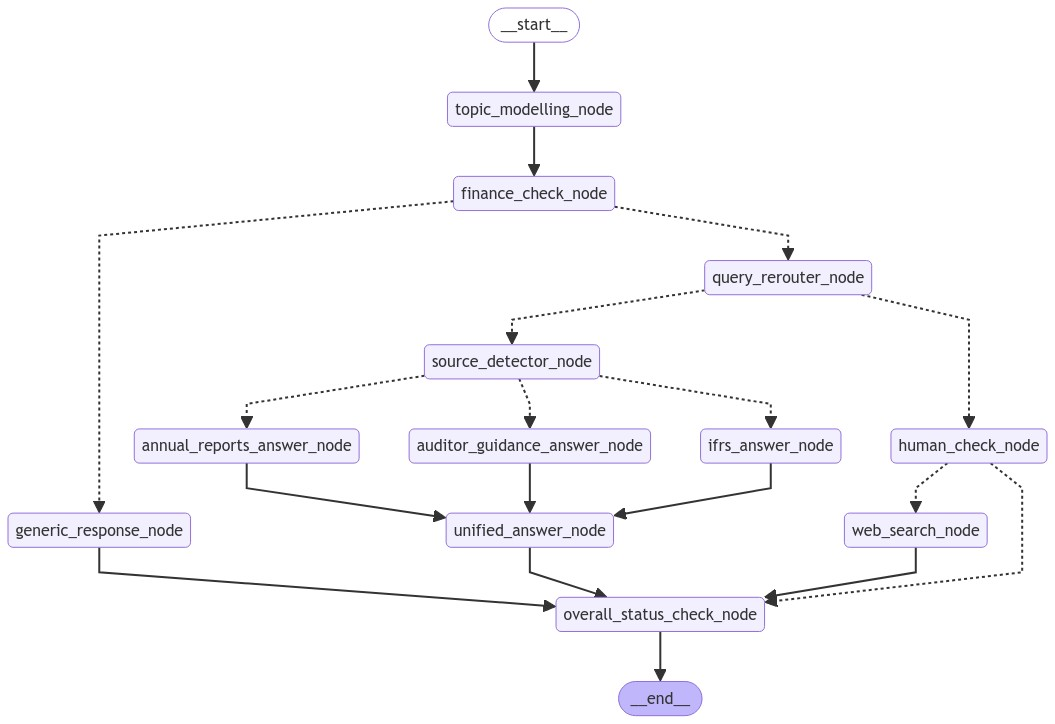

In [46]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [47]:
import time
from simple_colors import *

def run_answer(question, t):
    inputs = {"question": question, "operation_id": 123456, "user_id":"nalabsr1"}
    thread = {"configurable": {"thread_id": str(t)}}
    start_time = time.time()
    for output in graph.stream(inputs, thread, stream_mode='values'):
#         print(blue(output, ['bold']))
        pass
    ex_time = time.time() - start_time
    print("--------------------------------------------------------")
    print(red(f"Total Time Taken - [{round(ex_time, 2)}]", ['bold']))
    print("--------------------------------------------------------")
    return

In [48]:
question = "What is the income of bayer in 2024 Q1?"
run_answer(question, 89)

------ENTERING: TOPIC MODELLING NODE------
{'operation_id': 123456, 'user_id': 'nalabsr1', 'question': 'What is the income of bayer in 2024 Q1?', 'topic': None, 'requested_datasources': None, 'final_answer': '', 'finance_check': None, 'query_rerouter_check': None, 'source_detector_check': None, 'overall_status_check': None, 'generic_response': None, 'human_response': None, 'web_response': None, 'ifrs_response': None, 'annual_reports_response': None, 'audit_response': None, 'unified_response': None, 'intermediate_steps': []}
------OBSERVATION: DUMMY TOPIC------
------ENTERING: FINANCE CHECK NODE------
------OBSERVATION: Yes------
------DECISION: INVOKE QUERY REROUTER NODE------
------ENTERING: QUERY REROUTER NODE------
------OBSERVATION: WEB------
------DECISION: CHECK WITH USER TO INVOKE WEB SEARCH NODE------
The answer is not available from the private data sources! Do you want me to search over the internet to answer?yes
------DECISION: INVOKE WEB SEARCH NODE------
------ENTERING: WE

**FINAL ANSWER:** <font color="red">Bayer's financial results for the first quarter of 2024 have been published. Here are the key figures:

- **Group Sales**: €13.765 billion, which represents a slight decrease of 0.6% on a currency- and portfolio-adjusted basis compared to the previous year.
- **EBITDA before special items**: €4.412 billion, a decrease of 1.3%.

For more detailed information, you can refer to the official sources:
- [Bayer AG First Quarter 2024 Results and Media Update](https://www.bayer.com/media/en-us/bayer-ag-first-quarter-2024-results-and-media-update/)
- [Q1 2024 Results | Bayer Global](https://www.bayer.com/en/investors/q1-2024-investor-video-call)
- [Bayer Quarterly Statement First Quarter 2024 - MarketScreener](https://www.marketscreener.com/quote/stock/BAYER-AG-436063/news/Bayer-Quarterly-Statement-First-Quarter-2024-46805160/)

These sources provide comprehensive insights into Bayer's financial performance for the first quarter of 2024.</font>

--------------------------------------------------------
Total Time Taken - [11.77]
--------------------------------------------------------


In [50]:
question = "What is the guidance for identifying a lease as per IFRS?"
run_answer(question, 89)

------ENTERING: TOPIC MODELLING NODE------
{'operation_id': 123456, 'user_id': 'nalabsr1', 'question': 'What is the guidance for identifying a lease as per IFRS?', 'topic': None, 'requested_datasources': None, 'final_answer': '', 'finance_check': None, 'query_rerouter_check': None, 'source_detector_check': None, 'overall_status_check': None, 'generic_response': None, 'human_response': None, 'web_response': None, 'ifrs_response': None, 'annual_reports_response': None, 'audit_response': None, 'unified_response': None, 'intermediate_steps': []}
------OBSERVATION: DUMMY TOPIC------
------ENTERING: FINANCE CHECK NODE------
------OBSERVATION: Yes------
------DECISION: INVOKE QUERY REROUTER NODE------
------ENTERING: QUERY REROUTER NODE------
------OBSERVATION: FRA------
------DECISION: INVOKE SOURCE DETECTOR NODE------
------ENTERING: SOURCE DETECTOR NODE------
['ifrs_answer_node']
------SOURCES DETECTED: ['ifrs_answer_node']------
------ENTERING: IFRS ANSWER NODE------


OperationalError: unable to open database file

In [ ]:
question = "How do I account for Gains on sales of fixed assets?"
run_answer(question, 89)

{'operation_id': 123456, 'user_id': 'nalabsr1', 'question': 'How do I account for Gains on sales of fixed assets?', 'final_answer': '', 'intermediate_steps': []}
------ENTERING: TOPIC MODELLING NODE------
{'operation_id': 123456, 'user_id': 'nalabsr1', 'question': 'How do I account for Gains on sales of fixed assets?', 'topic': None, 'requested_datasources': None, 'final_answer': '', 'finance_check': None, 'query_rerouter_check': None, 'source_detector_check': None, 'overall_status_check': None, 'generic_response': None, 'web_response': None, 'ifrs_response': None, 'annual_reports_response': None, 'fm_response': None, 'unified_response': None, 'intermediate_steps': []}
------OBSERVATION: DUMMY TOPIC------
{'operation_id': 123456, 'user_id': 'nalabsr1', 'question': 'How do I account for Gains on sales of fixed assets?', 'topic': 'DUMMY TOPIC', 'final_answer': '', 'intermediate_steps': []}
------ENTERING: FINANCE CHECK NODE------
------OBSERVATION: Yes------
------DECISION: INVOKE QUERY 

**IFRS ANSWER:** <font color="red">As per IAS 16, gains on the sale of fixed assets (property, plant, and equipment) should be accounted for as follows:

- **Derecognition**: The carrying amount of the asset should be derecognized at the date of disposal (paragraph 67-72).
- **Recognition of Gain or Loss**: Any gain or loss arising from the derecognition of the asset should be recognized in profit or loss. This gain or loss is calculated as the difference between the net disposal proceeds and the carrying amount of the asset (paragraph 71).

Therefore, the gain on the sale of fixed assets should be recognized in the profit or loss statement at the date of derecognition.</font>

**FOUNDATIONAL ANSWER:** <font color="red">To account for gains on the sale of fixed assets, you need to follow the guidance provided by IAS 16 "Property, Plant and Equipment" and IFRS 5 "Non-current Assets Held for Sale and Discontinued Operations" if applicable.

### Step-by-Step Accounting for Gains on Sales of Fixed Assets:

1. **Determine the Carrying Amount:**
   - The carrying amount of the fixed asset is its cost less any accumulated depreciation and any accumulated impairment losses (IAS 16.6).

2. **Calculate the Gain:**
   - The gain on the sale of a fixed asset is calculated as the difference between the net disposal proceeds and the carrying amount of the asset at the time of sale (IAS 16.71).

3. **Recognize the Gain:**
   - The gain should be recognized in profit or loss when the asset is derecognized (IAS 16.68). Derecognition occurs when the asset is disposed of or when no future economic benefits are expected from its use or disposal (IAS 16.67).

4. **Presentation in Financial Statements:**
   - Gains on the sale of fixed assets should be presented in the income statement as part of other income or separately if material (IAS 1.97).

### Example Journal Entry:
Assume a fixed asset with a carrying amount of $50,000 is sold for $70,000.

- **Journal Entry:**
  - Debit: Cash/Bank $70,000
  - Credit: Fixed Asset $50,000
  - Credit: Gain on Sale of Fixed Asset $20,000

### Relevant IFRS/IAS Paragraphs:
- **IAS 16.6:** Definition of carrying amount.
- **IAS 16.67:** Derecognition of an asset.
- **IAS 16.68:** Recognition of gain or loss on derecognition.
- **IAS 16.71:** Calculation of gain or loss on disposal.
- **IAS 1.97:** Presentation of gains in the income statement.

### Sources:
- IAS 16 "Property, Plant and Equipment"
- IAS 1 "Presentation of Financial Statements"

By following these steps and referencing the relevant IFRS/IAS paragraphs, you can accurately account for gains on the sale of fixed assets in compliance with international financial reporting standards.</font>

**ANNUAL REPORTS ANSWER:** <font color="red">NO GUIDANCE</font>

{'operation_id': 123456, 'user_id': 'nalabsr1', 'question': 'How do I account for Gains on sales of fixed assets?', 'topic': 'DUMMY TOPIC', 'final_answer': '', 'finance_check': {'observation': 'Yes'}, 'query_rerouter_check': {'observation': 'FRA'}, 'source_detector_check': {'observation': ['annual_reports_answer_node', 'fm_answer_node', 'ifrs_answer_node']}, 'ifrs_response': {'answer': 'As per IAS 16, gains on the sale of fixed assets (property, plant, and equipment) should be accounted for as follows:\n\n- **Derecognition**: The carrying amount of the asset should be derecognized at the date of disposal (paragraph 67-72).\n- **Recognition of Gain or Loss**: Any gain or loss arising from the derecognition of the asset should be recognized in profit or loss. This gain or loss is calculated as the difference between the net disposal proceeds and the carrying amount of the asset (paragraph 71).\n\nTherefore, the gain on the sale of fixed assets should be recognized in the profit or loss s

<IPython.core.display.JSON object>

**UNIFIED ANSWER:** <font color="red">To account for gains on the sale of fixed assets, follow the guidance provided by IAS 16 "Property, Plant, and Equipment."

### Step-by-Step Accounting for Gains on Sales of Fixed Assets:

1. **Derecognition**: The carrying amount of the asset should be derecognized at the date of disposal (IAS 16.67-72).
2. **Calculate the Gain**: The gain is calculated as the difference between the net disposal proceeds and the carrying amount of the asset (IAS 16.71).
3. **Recognition of Gain**: Any gain arising from the derecognition of the asset should be recognized in profit or loss (IAS 16.68).
4. **Presentation in Financial Statements**: Gains on the sale of fixed assets should be presented in the income statement as part of other income or separately if material (IAS 1.97).

### Example Journal Entry:
Assume a fixed asset with a carrying amount of $50,000 is sold for $70,000.

- **Journal Entry:**
  - Debit: Cash/Bank $70,000
  - Credit: Fixed Asset $50,000
  - Credit: Gain on Sale of Fixed Asset $20,000

### Relevant IFRS/IAS Paragraphs:
- **IAS 16.6**: Definition of carrying amount.
- **IAS 16.67**: Derecognition of an asset.
- **IAS 16.68**: Recognition of gain or loss on derecognition.
- **IAS 16.71**: Calculation of gain or loss on disposal.
- **IAS 1.97**: Presentation of gains in the income statement.

By following these steps and referencing the relevant IFRS/IAS paragraphs, you can accurately account for gains on the sale of fixed assets in compliance with international financial reporting standards.</font>

{'operation_id': 123456, 'user_id': 'nalabsr1', 'question': 'How do I account for Gains on sales of fixed assets?', 'topic': 'DUMMY TOPIC', 'final_answer': '### IFRS: \nAs per IAS 16, gains on the sale of fixed assets (property, plant, and equipment) should be accounted for as follows:\n\n- **Derecognition**: The carrying amount of the asset should be derecognized at the date of disposal (paragraph 67-72).\n- **Recognition of Gain or Loss**: Any gain or loss arising from the derecognition of the asset should be recognized in profit or loss. This gain or loss is calculated as the difference between the net disposal proceeds and the carrying amount of the asset (paragraph 71).\n\nTherefore, the gain on the sale of fixed assets should be recognized in the profit or loss statement at the date of derecognition.\n\n---\n\n### Annual Reports: \nNO GUIDANCE\n\n---\n\n### Foundational ChatGPT: \nTo account for gains on the sale of fixed assets, you need to follow the guidance provided by IAS 16

**FINAL ANSWER:** <font color="red">### IFRS: 
As per IAS 16, gains on the sale of fixed assets (property, plant, and equipment) should be accounted for as follows:

- **Derecognition**: The carrying amount of the asset should be derecognized at the date of disposal (paragraph 67-72).
- **Recognition of Gain or Loss**: Any gain or loss arising from the derecognition of the asset should be recognized in profit or loss. This gain or loss is calculated as the difference between the net disposal proceeds and the carrying amount of the asset (paragraph 71).

Therefore, the gain on the sale of fixed assets should be recognized in the profit or loss statement at the date of derecognition.

---

### Annual Reports: 
NO GUIDANCE

---

### Foundational ChatGPT: 
To account for gains on the sale of fixed assets, you need to follow the guidance provided by IAS 16 "Property, Plant and Equipment" and IFRS 5 "Non-current Assets Held for Sale and Discontinued Operations" if applicable.

### Step-by-Step Accounting for Gains on Sales of Fixed Assets:

1. **Determine the Carrying Amount:**
   - The carrying amount of the fixed asset is its cost less any accumulated depreciation and any accumulated impairment losses (IAS 16.6).

2. **Calculate the Gain:**
   - The gain on the sale of a fixed asset is calculated as the difference between the net disposal proceeds and the carrying amount of the asset at the time of sale (IAS 16.71).

3. **Recognize the Gain:**
   - The gain should be recognized in profit or loss when the asset is derecognized (IAS 16.68). Derecognition occurs when the asset is disposed of or when no future economic benefits are expected from its use or disposal (IAS 16.67).

4. **Presentation in Financial Statements:**
   - Gains on the sale of fixed assets should be presented in the income statement as part of other income or separately if material (IAS 1.97).

### Example Journal Entry:
Assume a fixed asset with a carrying amount of $50,000 is sold for $70,000.

- **Journal Entry:**
  - Debit: Cash/Bank $70,000
  - Credit: Fixed Asset $50,000
  - Credit: Gain on Sale of Fixed Asset $20,000

### Relevant IFRS/IAS Paragraphs:
- **IAS 16.6:** Definition of carrying amount.
- **IAS 16.67:** Derecognition of an asset.
- **IAS 16.68:** Recognition of gain or loss on derecognition.
- **IAS 16.71:** Calculation of gain or loss on disposal.
- **IAS 1.97:** Presentation of gains in the income statement.

### Sources:
- IAS 16 "Property, Plant and Equipment"
- IAS 1 "Presentation of Financial Statements"

By following these steps and referencing the relevant IFRS/IAS paragraphs, you can accurately account for gains on the sale of fixed assets in compliance with international financial reporting standards.

---

### Unified Response
To account for gains on the sale of fixed assets, follow the guidance provided by IAS 16 "Property, Plant, and Equipment."

### Step-by-Step Accounting for Gains on Sales of Fixed Assets:

1. **Derecognition**: The carrying amount of the asset should be derecognized at the date of disposal (IAS 16.67-72).
2. **Calculate the Gain**: The gain is calculated as the difference between the net disposal proceeds and the carrying amount of the asset (IAS 16.71).
3. **Recognition of Gain**: Any gain arising from the derecognition of the asset should be recognized in profit or loss (IAS 16.68).
4. **Presentation in Financial Statements**: Gains on the sale of fixed assets should be presented in the income statement as part of other income or separately if material (IAS 1.97).

### Example Journal Entry:
Assume a fixed asset with a carrying amount of $50,000 is sold for $70,000.

- **Journal Entry:**
  - Debit: Cash/Bank $70,000
  - Credit: Fixed Asset $50,000
  - Credit: Gain on Sale of Fixed Asset $20,000

### Relevant IFRS/IAS Paragraphs:
- **IAS 16.6**: Definition of carrying amount.
- **IAS 16.67**: Derecognition of an asset.
- **IAS 16.68**: Recognition of gain or loss on derecognition.
- **IAS 16.71**: Calculation of gain or loss on disposal.
- **IAS 1.97**: Presentation of gains in the income statement.

By following these steps and referencing the relevant IFRS/IAS paragraphs, you can accurately account for gains on the sale of fixed assets in compliance with international financial reporting standards.

</font>

{'operation_id': 123456, 'user_id': 'nalabsr1', 'question': 'How do I account for Gains on sales of fixed assets?', 'topic': 'DUMMY TOPIC', 'final_answer': '### IFRS: \nAs per IAS 16, gains on the sale of fixed assets (property, plant, and equipment) should be accounted for as follows:\n\n- **Derecognition**: The carrying amount of the asset should be derecognized at the date of disposal (paragraph 67-72).\n- **Recognition of Gain or Loss**: Any gain or loss arising from the derecognition of the asset should be recognized in profit or loss. This gain or loss is calculated as the difference between the net disposal proceeds and the carrying amount of the asset (paragraph 71).\n\nTherefore, the gain on the sale of fixed assets should be recognized in the profit or loss statement at the date of derecognition.\n\n---\n\n### Annual Reports: \nNO GUIDANCE\n\n---\n\n### Foundational ChatGPT: \nTo account for gains on the sale of fixed assets, you need to follow the guidance provided by IAS 16

In [ ]:
question = "Where do i find company master data change request form?"
run_answer(question, 19)

{'operation_id': 123456, 'user_id': 'nalabsr1', 'question': 'Where do i find company master data change request form?', 'final_answer': '', 'intermediate_steps': []}
------ENTERING: TOPIC MODELLING NODE------
{'operation_id': 123456, 'user_id': 'nalabsr1', 'question': 'Where do i find company master data change request form?', 'topic': None, 'requested_datasources': None, 'final_answer': '', 'finance_check': None, 'query_rerouter_check': None, 'source_detector_check': None, 'overall_status_check': None, 'generic_response': None, 'web_response': None, 'ifrs_response': None, 'annual_reports_response': None, 'fm_response': None, 'unified_response': None, 'intermediate_steps': []}
------OBSERVATION: DUMMY TOPIC------
{'operation_id': 123456, 'user_id': 'nalabsr1', 'question': 'Where do i find company master data change request form?', 'topic': 'DUMMY TOPIC', 'final_answer': '', 'intermediate_steps': []}
------ENTERING: FINANCE CHECK NODE------
------OBSERVATION: Yes------
------DECISION: I

**IFRS ANSWER:** <font color="red">NO GUIDANCE</font>

**ANNUAL REPORTS ANSWER:** <font color="red">You can find the company master data change request form on the Novartis Supplier Portal. Here is the link to access it: [Novartis Supplier Portal](https://www.novartis.com/supplier-portal).</font>

**FOUNDATIONAL ANSWER:** <font color="red">To find the company master data change request form at Novartis, you should typically refer to the internal resources provided by the company's finance or IT departments. This form is usually part of the internal control processes and is used to ensure that any changes to the master data are properly documented and authorized.

Here are the steps you can follow to locate the form:

1. **Intranet or Internal Portal**: Check the Novartis intranet or internal employee portal. These platforms often have sections dedicated to forms and templates, including those for financial and administrative purposes.

2. **Finance Department**: Contact the finance department directly. They can provide you with the necessary forms and guide you through the process of submitting a change request.

3. **IT Support**: Sometimes, the IT department manages the master data systems. They can also provide the form or direct you to the appropriate resource.

4. **Internal Policies and Procedures Manual**: Refer to the internal policies and procedures manual, which may include instructions on how to request changes to company master data and where to find the relevant forms.

5. **SAP or ERP System**: If Novartis uses an ERP system like SAP, the form might be available within the system itself. You can check the help section or contact the system administrator for assistance.

Since this is an internal document, it is not governed by IFRS or IAS standards, and there are no specific paragraphs from these standards that apply to the location of the form. However, maintaining accurate and up-to-date master data is crucial for financial reporting and compliance with standards such as IFRS 7 (Financial Instruments: Disclosures) and IFRS 9 (Financial Instruments), which require accurate data for proper financial disclosures.

For further assistance, you may refer to internal communication channels or consult with your supervisor or manager.</font>

{'operation_id': 123456, 'user_id': 'nalabsr1', 'question': 'Where do i find company master data change request form?', 'topic': 'DUMMY TOPIC', 'final_answer': '', 'finance_check': {'observation': 'Yes'}, 'query_rerouter_check': {'observation': 'FRA'}, 'source_detector_check': {'observation': ['annual_reports_answer_node', 'fm_answer_node', 'ifrs_answer_node']}, 'ifrs_response': {'answer': 'NO GUIDANCE', 'metadata': []}, 'annual_reports_response': {'answer': 'You can find the company master data change request form on the Novartis Supplier Portal. Here is the link to access it: [Novartis Supplier Portal](https://www.novartis.com/supplier-portal).', 'metadata': []}, 'fm_response': {'answer': "To find the company master data change request form at Novartis, you should typically refer to the internal resources provided by the company's finance or IT departments. This form is usually part of the internal control processes and is used to ensure that any changes to the master data are proper

<IPython.core.display.JSON object>

**UNIFIED ANSWER:** <font color="red">To find the company master data change request form at Novartis, you can access it on the [Novartis Supplier Portal](https://www.novartis.com/supplier-portal). This form is part of the internal control processes to ensure that any changes to the master data are properly documented and authorized. For further assistance, you may refer to internal communication channels or consult with your supervisor or manager.</font>

{'operation_id': 123456, 'user_id': 'nalabsr1', 'question': 'Where do i find company master data change request form?', 'topic': 'DUMMY TOPIC', 'final_answer': "### IFRS: \nNO GUIDANCE\n\n---\n\n### Annual Reports: \nYou can find the company master data change request form on the Novartis Supplier Portal. Here is the link to access it: [Novartis Supplier Portal](https://www.novartis.com/supplier-portal).\n\n---\n\n### Foundational ChatGPT: \nTo find the company master data change request form at Novartis, you should typically refer to the internal resources provided by the company's finance or IT departments. This form is usually part of the internal control processes and is used to ensure that any changes to the master data are properly documented and authorized.\n\nHere are the steps you can follow to locate the form:\n\n1. **Intranet or Internal Portal**: Check the Novartis intranet or internal employee portal. These platforms often have sections dedicated to forms and templates, in

**FINAL ANSWER:** <font color="red">### IFRS: 
NO GUIDANCE

---

### Annual Reports: 
You can find the company master data change request form on the Novartis Supplier Portal. Here is the link to access it: [Novartis Supplier Portal](https://www.novartis.com/supplier-portal).

---

### Foundational ChatGPT: 
To find the company master data change request form at Novartis, you should typically refer to the internal resources provided by the company's finance or IT departments. This form is usually part of the internal control processes and is used to ensure that any changes to the master data are properly documented and authorized.

Here are the steps you can follow to locate the form:

1. **Intranet or Internal Portal**: Check the Novartis intranet or internal employee portal. These platforms often have sections dedicated to forms and templates, including those for financial and administrative purposes.

2. **Finance Department**: Contact the finance department directly. They can provide you with the necessary forms and guide you through the process of submitting a change request.

3. **IT Support**: Sometimes, the IT department manages the master data systems. They can also provide the form or direct you to the appropriate resource.

4. **Internal Policies and Procedures Manual**: Refer to the internal policies and procedures manual, which may include instructions on how to request changes to company master data and where to find the relevant forms.

5. **SAP or ERP System**: If Novartis uses an ERP system like SAP, the form might be available within the system itself. You can check the help section or contact the system administrator for assistance.

Since this is an internal document, it is not governed by IFRS or IAS standards, and there are no specific paragraphs from these standards that apply to the location of the form. However, maintaining accurate and up-to-date master data is crucial for financial reporting and compliance with standards such as IFRS 7 (Financial Instruments: Disclosures) and IFRS 9 (Financial Instruments), which require accurate data for proper financial disclosures.

For further assistance, you may refer to internal communication channels or consult with your supervisor or manager.

---

### Unified Response
To find the company master data change request form at Novartis, you can access it on the [Novartis Supplier Portal](https://www.novartis.com/supplier-portal). This form is part of the internal control processes to ensure that any changes to the master data are properly documented and authorized. For further assistance, you may refer to internal communication channels or consult with your supervisor or manager.

</font>

{'operation_id': 123456, 'user_id': 'nalabsr1', 'question': 'Where do i find company master data change request form?', 'topic': 'DUMMY TOPIC', 'final_answer': "### IFRS: \nNO GUIDANCE\n\n---\n\n### Annual Reports: \nYou can find the company master data change request form on the Novartis Supplier Portal. Here is the link to access it: [Novartis Supplier Portal](https://www.novartis.com/supplier-portal).\n\n---\n\n### Foundational ChatGPT: \nTo find the company master data change request form at Novartis, you should typically refer to the internal resources provided by the company's finance or IT departments. This form is usually part of the internal control processes and is used to ensure that any changes to the master data are properly documented and authorized.\n\nHere are the steps you can follow to locate the form:\n\n1. **Intranet or Internal Portal**: Check the Novartis intranet or internal employee portal. These platforms often have sections dedicated to forms and templates, in